In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import semopy as sem
import networkx as nx
from scipy import stats

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import graphviz
from sklearn.tree import export_graphviz


In [2]:
df = pd.read_csv("Dataset.csv")
df.head()
# pd.set_option('display.max_columns',None)


,address,bank,atm_id,coord_x,coord_y,freguesia,parish,mway_dist,police_dis,income,...,indirect_loss,net_loss,freq_attack,success_attack,n_income,n_density,n_age,n_unp_rate,n_com_dens,n_freq_attack
0,Rua Tomas Da Fonseca TR a Lisbon,BANCO BPI S.A.,BPI17,-9.17093,38.75610,Lumiar,12,195.353440,898.569719,52,...,0,25,4,1,5,2,2,1,2,1
1,Estrada De Telheiras Lisbon,BANCO COMERCIAL PORTUGUES,CP01,-9.15911,38.76020,Lumiar,12,190.831787,568.679321,56,...,0,70,3,1,5,1,2,1,2,1
2,Rua Abranches Ferrao 8C Lisbon,BANCO COMERCIAL PORTUGUES,CP52,-9.17203,38.75064,Carnide,10,766.671635,1432.302696,52,...,0,5000,3,1,5,1,2,2,2,1
3,Avenida Dom Vasco Da Gama 50 a Lisbon,BANCO SANTANDER TOTTA,ST98,-9.22544,38.69942,Belém,6,192.282794,1143.736479,36,...,65000,65000,3,0,3,2,4,4,2,1
4,Rua Abranches Ferrao 17-B Lisbon,BARCLAYS BANK,BB07,-9.17070,38.75117,Lumiar,12,719.798770,1371.942724,58,...,0,80,2,1,6,3,1,2,2,1


In [3]:
# Grouping by 'freguesia' and aggregating to get the total number of ATMs and the number of attacked ATMs
grouped_df = df.groupby('freguesia').agg({'atm_id': 'count', 'freq_attack': 'sum','success_attack':'sum'}).reset_index()

grouped_df.head()

,freguesia,atm_id,freq_attack,success_attack
0,Alcântara,22,0,0
1,Alvalade,41,1,1
2,Areeiro,8,0,0
3,Arroios,66,0,0
4,Avenidas Novas,124,19,15


In [4]:



# Load the Freguesias shapefile
freguesia_gdf = gpd.read_file('shapefiles/Freguesias2012.shp')

# Create a GeoDataFrame from the DataFrame
geometry = gpd.points_from_xy(df['coord_x'], df['coord_y'])
points_gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Perform a spatial join between the points GeoDataFrame and the Freguesias GeoDataFrame
joined_gdf = gpd.sjoin(points_gdf, freguesia_gdf, how='left')

# Check the resulting DataFrame
joined_gdf.head()


,address,bank,atm_id,coord_x,coord_y,freguesia,parish,mway_dist,police_dis,income,...,freq_attack,success_attack,n_income,n_density,n_age,n_unp_rate,n_com_dens,n_freq_attack,geometry,index_right
0,Rua Tomas Da Fonseca TR a Lisbon,BANCO BPI S.A.,BPI17,-9.17093,38.75610,Lumiar,12,195.353440,898.569719,52,...,4,1,5,2,2,1,2,1,POINT (-9.17093 38.75610),11
1,Estrada De Telheiras Lisbon,BANCO COMERCIAL PORTUGUES,CP01,-9.15911,38.76020,Lumiar,12,190.831787,568.679321,56,...,3,1,5,1,2,1,2,1,POINT (-9.15911 38.76020),5
2,Rua Abranches Ferrao 8C Lisbon,BANCO COMERCIAL PORTUGUES,CP52,-9.17203,38.75064,Carnide,10,766.671635,1432.302696,52,...,3,1,5,1,2,2,2,1,POINT (-9.17203 38.75064),11
3,Avenida Dom Vasco Da Gama 50 a Lisbon,BANCO SANTANDER TOTTA,ST98,-9.22544,38.69942,Belém,6,192.282794,1143.736479,36,...,3,0,3,2,4,4,2,1,POINT (-9.22544 38.69942),2
4,Rua Abranches Ferrao 17-B Lisbon,BARCLAYS BANK,BB07,-9.17070,38.75117,Lumiar,12,719.798770,1371.942724,58,...,2,1,6,3,1,2,2,1,POINT (-9.17070 38.75117),11


In [5]:
import pandas as pd
import plotly.graph_objects as go

# Grouping by 'freguesia' and aggregating to get the total number of ATMs, the number of attacked ATMs, and the number of successful attacks
grouped_df = df.groupby('freguesia').agg({'atm_id': 'count', 'freq_attack': 'sum', 'success_attack': 'sum'}).reset_index()

# Filter to keep only freguesias where attacks have occurred
attacked_df = grouped_df[grouped_df['freq_attack'] > 0]

# Sort the DataFrame by 'freguesia'
attacked_df = attacked_df.sort_values(by='freguesia')

# Create the figure
fig = go.Figure()

# Add total ATMs line
fig.add_trace(go.Scatter(
    x=attacked_df['freguesia'],
    y=attacked_df['atm_id'],
    mode='lines+markers',
    name='Total ATMs',
    line=dict(color='gray', width=2),
    marker=dict(color='gray', size=8, symbol='circle'),
))

# Add frequency of attacked ATMs line
fig.add_trace(go.Scatter(
    x=attacked_df['freguesia'],
    y=attacked_df['freq_attack'],
    mode='lines+markers',
    name='Attacked ATMs',
    line=dict(color='red', width=2),
    marker=dict(color='red', size=8, symbol='square'),
))

# Add success of attacked ATMs line
fig.add_trace(go.Scatter(
    x=attacked_df['freguesia'],
    y=attacked_df['success_attack'],
    mode='lines+markers',
    name='Successful Attacks',
    line=dict(color='green', width=2),
    marker=dict(color='green', size=8, symbol='diamond'),
))

# Update the layout
fig.update_layout(
    title='Number of ATMs vs Attacked ATMs vs Successful Attacks by Freguesia',
    xaxis=dict(title='Freguesia'),
    yaxis=dict(title='Number of ATMs / Attacks'),
    overwrite=True
)

# Show the figure
fig.show()


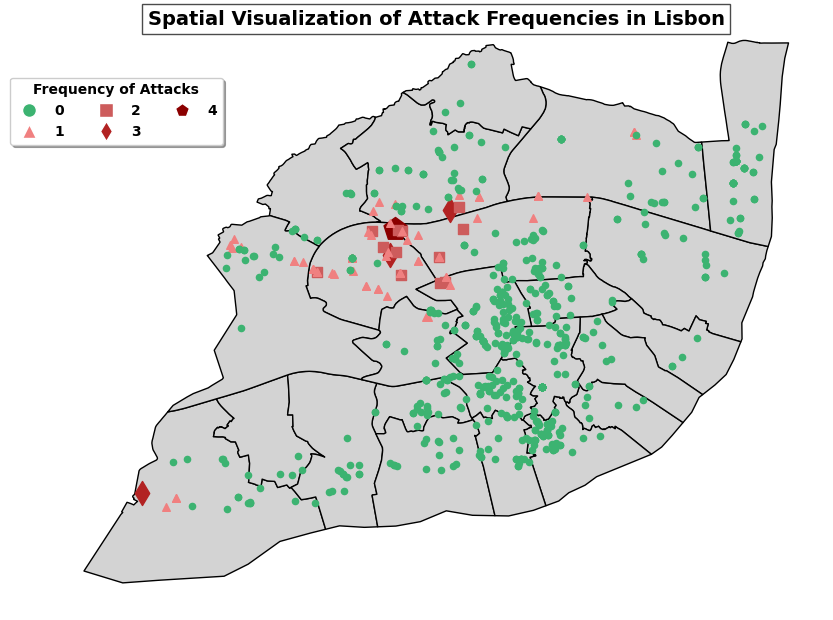

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # To create custom legend markers

# Load the shapefile of Lisbon
lisbon_map = gpd.read_file("shapefiles/Freguesias2012.shp")

# Plotting
fig, ax = plt.subplots( figsize=(10, 10))
fig.patch.set_alpha(0.0)
# Plotting the map
lisbon_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Define marker size based on frequency of attacks
def marker_size(freq):
    if freq == 0:
        return 20
    elif freq == 1:
        return 30
    elif freq == 2:
        return 50
    elif freq == 3:
        return 150
    elif freq == 4:
        return 300

# Define a function to map frequency of attacks to marker shapes and colors
def shape_color_map(freq):
    shape_map = {0: 'o', 1: '^', 2: 's', 3: 'd', 4: 'p'}  # Mapping of frequency to marker shapes
    color_map = {0: 'mediumseagreen', 1: 'lightcoral', 2: 'indianred',  3: 'firebrick', 4: 'darkred'}  # Mapping of frequency to colors
    return shape_map.get(freq, 'o'), color_map.get(freq, 'lightyellow')

# Plotting the points with color and shape based on frequency of attacks
for idx, row in joined_gdf.iterrows():
    shape, color = shape_color_map(row['freq_attack'])
    size = marker_size(row['freq_attack'])
    ax.scatter(row.geometry.x, row.geometry.y, color=color, s=size, marker=shape)

# Adding a legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='mediumseagreen', markersize=10),
                   Line2D([0], [0], marker='^', color='w', label='1', markerfacecolor='lightcoral', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='2', markerfacecolor='indianred', markersize=10),
                   Line2D([0], [0], marker='d', color='w', label='3', markerfacecolor='firebrick', markersize=10),
                   Line2D([0], [0], marker='p', color='w', label='4', markerfacecolor='darkred', markersize=10)]
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.legend(handles=legend_elements, title='Frequency of Attacks', loc=(-0.05,0.780), ncol=3 ,
          prop={'weight':'bold'}, shadow=True,title_fontproperties={'weight': 'bold'})

# Adding a caption
ax.text(0.5, 0.99, 'Spatial Visualization of Attack Frequencies in Lisbon', horizontalalignment='center', verticalalignment='center',transform=ax.transAxes,
        fontsize=14, weight='bold', bbox=dict( facecolor='white',alpha=0.7, edgecolor='black'))

plt.show()


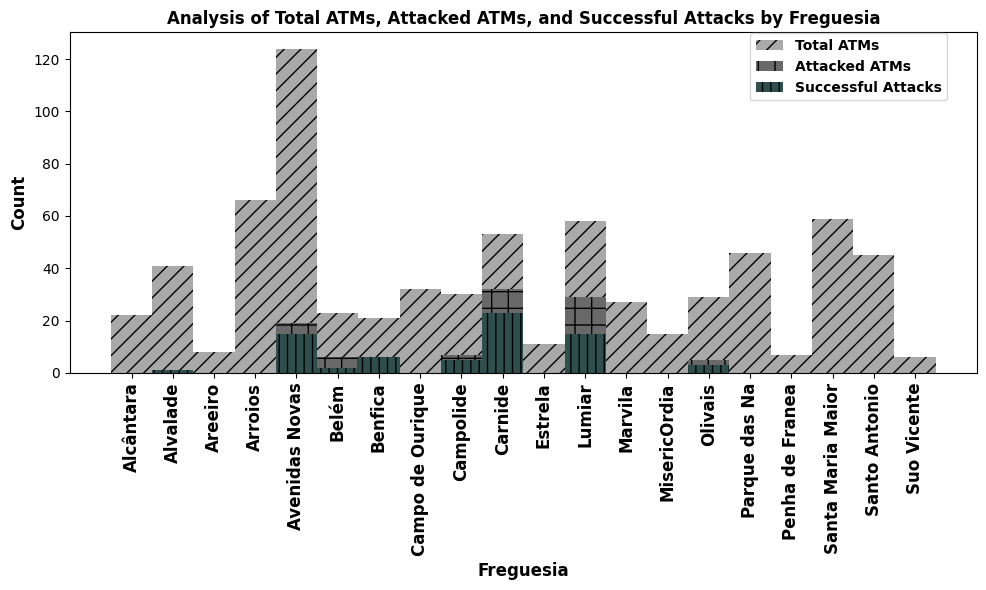

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars
bar_width = 1

# Set the figure size
plt.figure(figsize=(10, 6))

# Plotting the stacked bars for total ATMs, attacked ATMs, and successful attacks
total_bars = plt.bar(np.arange(len(grouped_df['freguesia'])), grouped_df['atm_id'], bar_width, color='#A9A9A9', label='Total ATMs',hatch='//')
attacked_bars = plt.bar(np.arange(len(grouped_df['freguesia'])), grouped_df['freq_attack'], bar_width, color='#696969', label='Attacked ATMs',hatch='+')
success_bars = plt.bar(np.arange(len(grouped_df['freguesia'])), grouped_df['success_attack'], bar_width, color='#2F4F4F', label='Successful Attacks',hatch='||')

# Adding labels and title
plt.xlabel('Freguesia',fontdict={"weight":'bold','size':"large"})
plt.ylabel('Count',fontdict={"weight":'bold','size':"large"})
plt.title('Analysis of Total ATMs, Attacked ATMs, and Successful Attacks by Freguesia',fontdict={'weight':'bold'})
plt.xticks(np.arange(len(grouped_df['freguesia'])), grouped_df['freguesia'], rotation=90,fontsize=12, weight='bold')
plt.legend(loc=(0.75, 0.8), prop={'weight': 'bold'})

# Display the plot
plt.tight_layout()
plt.show()



                mway_dist  police_dis  parish  income  density    age  \
mway_dist           False        True    True   False     True   True   
police_dis           True       False   False   False     True   True   
parish               True       False   False   False     True   True   
income              False       False   False   False     True   True   
density              True        True    True    True    False   True   
age                  True        True    True    True     True  False   
unp_rate             True        True   False    True    False   True   
com_dens             True        True    True   False    False   True   
success_attack       True        True   False   False    False   True   

                unp_rate  com_dens  success_attack  
mway_dist           True      True            True  
police_dis          True      True            True  
parish             False      True           False  
income              True     False           False  
dens

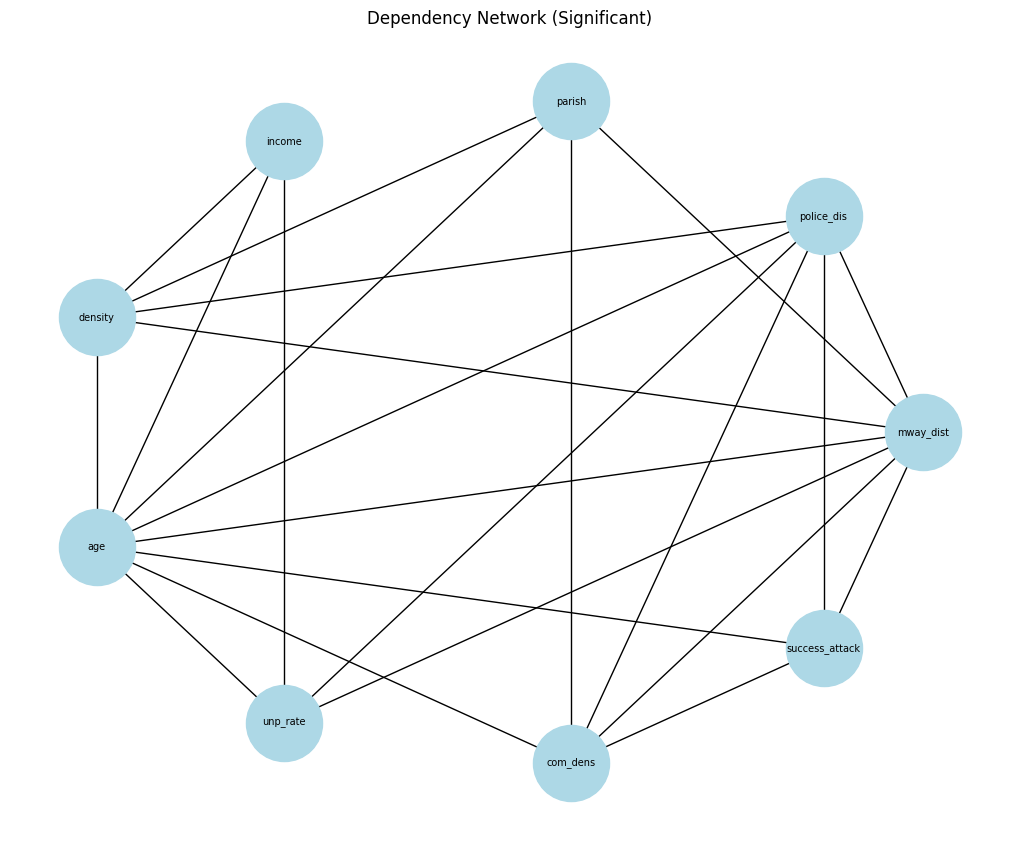

In [8]:


# Assuming numeric_df is your DataFrame containing numeric data
numeric_df= df[['mway_dist','police_dis','parish','income','density','age','unp_rate','com_dens','success_attack']]
# Compute p-values for pairwise dependencies
p_values = pd.DataFrame(index=numeric_df.columns, columns=numeric_df.columns)
for col1 in numeric_df.columns:
    for col2 in numeric_df.columns:
        if col1 != col2:
            corr, p_val = stats.pearsonr(numeric_df[col1], numeric_df[col2])
            p_values.loc[col1, col2] = p_val
# print(p_values)
# Thresholding (adjust threshold as needed)
alpha = 0.05  # Example significance level
dependency_matrix = p_values < alpha
print(dependency_matrix)
# Create network only with significant dependencies
G = nx.from_pandas_adjacency(dependency_matrix)

# Visualize network
plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)  # or any other layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=7)
plt.title("Dependency Network (Significant)")
plt.savefig('dependency_net_geo_demo_success.png')
plt.show()


                     Value
DoF              39.000000
DoF Baseline     52.000000
chi2             41.931951
chi2 p-value      0.344902
chi2 Baseline  2084.897104
CFI               0.998558
GFI               0.979888
AGFI              0.973184
NFI               0.979888
TLI               0.998077
RMSEA             0.010204
AIC              30.187155
BIC             103.521703
LogLik            0.906422
Name of objective: DWLS
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.058
Number of iterations: 51
Params: 0.015 -0.000 0.000 0.054 -0.008 -0.000 0.001 0.035 0.106 -0.010 0.009 -0.075 6.307 0.113 21.679 0.060
              lval  op            rval   Estimate  Std. Err    z-value  \
0           parish   ~               L   1.000000         -          -   
1                L   ~        com_dens   0.034589  0.011652    2.96849   
2                L   ~             age   0.105949   0.02062   5.138077   
3                L   ~      

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/pranam/snap/code/common/.cache/gio-modules/libgiolibproxy.so


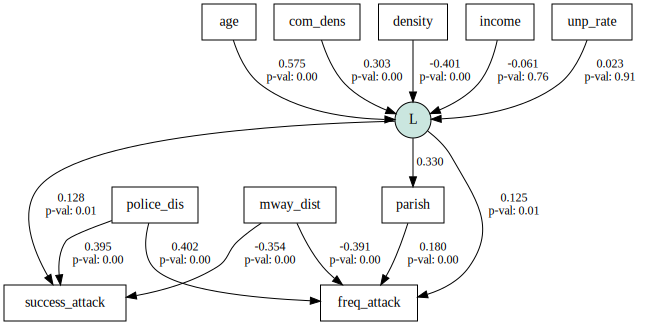

In [9]:
data= df[['mway_dist','police_dis','parish','income','density','age','unp_rate','com_dens','success_attack','freq_attack']]

formula = """


L =~ parish
success_attack ~ L + mway_dist + police_dis 
freq_attack ~ L + parish + mway_dist + police_dis
L ~ com_dens + age + income + unp_rate + density


"""

model = sem.Model(formula)

fit = model.fit(data, obj="DWLS", solver="SLSQP")  #  DWLS 
sem.bias_correction(model, n=500, resample_mean=False)
print(sem.calc_stats(model).T)
print(fit)
print(model.inspect())
sem.semplot(model, "semresultbias.png", plot_covs=True, std_ests=True, show=True)


# Decision Tree

In [10]:



# # Min-max normalization function
# def min_max_normalize(column):
#     return (column - column.min()) / (column.max() - column.min())

# # Apply normalization to the selected columns
# data_normalized = data.copy()
# data_normalized['mway_dist'] = min_max_normalize(data['mway_dist'])
# data_normalized['police_dis'] = min_max_normalize(data['police_dis'])

# # Success attack is already in the range [0, 1], so no need to normalize it
# # But if you want to ensure it's correctly normalized, you can uncomment the line below
# # data_normalized['success_attack'] = min_max_normalize(data['success_attack'])

# # print(data_normalized)


X = data[['mway_dist', 'police_dis']]  # Features
y = data['success_attack']  # Target variable

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Initialize and train the decision tree classifier on the balanced data
clf = DecisionTreeClassifier(criterion='entropy',max_depth=4,min_samples_leaf=15)  # You can change the criterion to 'gini' if preferred
clf.fit(X_resampled, y_resampled)

# Generate the rule-based decision tree
tree_rules = export_text(clf, feature_names=['mway_dist', 'police_dis'])

# Print the rules
print(tree_rules)

# Generate the DOT data for visualization
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=['mway_dist', 'police_dis'],  
                           class_names=['0', '1'],  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Visualize the decision tree
graph = graphviz.Source(dot_data)  
graph.format = 'png'  # Specify the image format (e.g., png, jpg, svg, pdf)
graph.render("decision_tree")






|--- mway_dist <= 925.69
|   |--- police_dis <= 580.14
|   |   |--- police_dis <= 510.19
|   |   |   |--- class: 0
|   |   |--- police_dis >  510.19
|   |   |   |--- mway_dist <= 508.18
|   |   |   |   |--- class: 1
|   |   |   |--- mway_dist >  508.18
|   |   |   |   |--- class: 0
|   |--- police_dis >  580.14
|   |   |--- mway_dist <= 727.78
|   |   |   |--- mway_dist <= 675.50
|   |   |   |   |--- class: 1
|   |   |   |--- mway_dist >  675.50
|   |   |   |   |--- class: 1
|   |   |--- mway_dist >  727.78
|   |   |   |--- police_dis <= 967.76
|   |   |   |   |--- class: 0
|   |   |   |--- police_dis >  967.76
|   |   |   |   |--- class: 1
|--- mway_dist >  925.69
|   |--- class: 0



eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


'decision_tree.png'

In [11]:
def extract_ranges(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]

    results = []

    def recurse(node, mway_range, police_range):
        if tree_.feature[node] != -2:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            if name == 'mway_dist':
                left_mway_range = mway_range.copy()
                right_mway_range = mway_range.copy()
                left_mway_range[1] = min(left_mway_range[1], threshold)
                right_mway_range[0] = max(right_mway_range[0], threshold)
                recurse(tree_.children_left[node], left_mway_range, police_range)
                recurse(tree_.children_right[node], right_mway_range, police_range)
            elif name == 'police_dis':
                left_police_range = police_range.copy()
                right_police_range = police_range.copy()
                left_police_range[1] = min(left_police_range[1], threshold)
                right_police_range[0] = max(right_police_range[0], threshold)
                recurse(tree_.children_left[node], mway_range, left_police_range)
                recurse(tree_.children_right[node], mway_range, right_police_range)
        else:
            samples_at_node = tree_.n_node_samples[node]
            value_at_node = tree_.value[node][0]
            attacked_samples = value_at_node[1]
            not_attacked_samples = value_at_node[0]
            total_samples = attacked_samples + not_attacked_samples
            attack_possible = attacked_samples > 0
            mway_range = [max(0, int(np.ceil(mway_range[0]))) if mway_range[0] != -np.inf else 0,
                          max(0, int(np.floor(mway_range[1]))) if mway_range[1] != np.inf else int(np.floor(tree_.threshold.max()))]
            police_range = [max(0, int(np.ceil(police_range[0]))) if police_range[0] != -np.inf else 0,
                            max(0, int(np.floor(police_range[1]))) if police_range[1] != np.inf else int(np.floor(tree_.threshold.max()))]
            results.append((mway_range, police_range, attack_possible))

    recurse(0, [-np.inf, np.inf], [-np.inf, np.inf])

    return results

def create_ranges_dataframe(tree, feature_names):
    ranges = extract_ranges(tree, feature_names)
    df = pd.DataFrame(ranges, columns=['Mway Range', 'Police Range', 'Attack Possible'])
    return df

# Create DataFrame for the ranges and attack possibilities
ranges_df = create_ranges_dataframe(clf, ['mway_dist', 'police_dis'])

# Print the ranges DataFrame
ranges_df

,Mway Range,Police Range,Attack Possible
0,"[0, 925]","[0, 510]",False
1,"[0, 508]","[511, 580]",True
2,"[509, 925]","[511, 580]",True
3,"[0, 675]","[581, 967]",True
4,"[676, 727]","[581, 967]",True
5,"[728, 925]","[581, 967]",False
6,"[728, 925]","[968, 967]",True
7,"[926, 967]","[0, 967]",False


In [12]:
for i in range(clf.tree_.node_count):
    print(f"Node {i}:")
    print("  Entropy:", clf.tree_.impurity[i])  # Calculate and print entropy for the node
    # Calculate and print Gini impurity for the node
    class_distribution = clf.tree_.value[i][0]  # Get class distribution
    total_samples = clf.tree_.n_node_samples[i]  # Get total number of samples
    print("  Number of Samples:", total_samples)
    print("  Value (Class Distribution):", class_distribution)
    predicted_class_index = class_distribution.argmax()
    predicted_class = clf.classes_[predicted_class_index]
    print("  Predicted Class:", predicted_class)
    print()
# Function to calculate attack and not attacked percentages for each node
def calculate_node_percentages(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != -2:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else:  # if {name} > {threshold:.2f}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            samples_at_node = tree_.n_node_samples[node]
            value_at_node = tree_.value[node][0]
            attacked_samples = value_at_node[1]
            not_attacked_samples = value_at_node[0]
            total_samples = attacked_samples + not_attacked_samples
            attack_percentage = (attacked_samples / total_samples) * 100 if total_samples > 0 else 0
            not_attack_percentage = (not_attacked_samples / total_samples) * 100 if total_samples > 0 else 0
            print(f"{indent}samples = {samples_at_node}")
            print(f"{indent}attacked = {attacked_samples}")
            print(f"{indent}not attacked = {not_attacked_samples}")
            print(f"{indent}attack percentage = {attack_percentage:.2f}%")
            print(f"{indent}not attack percentage = {not_attack_percentage:.2f}%")
    
    recurse(0, 0)
    # Calculate and print attack percentages for each node
calculate_node_percentages(clf, ['mway_dist', 'police_dis'])


Node 0:
  Entropy: 1.0
  Number of Samples: 1306
  Value (Class Distribution): [0.5 0.5]
  Predicted Class: 0

Node 1:
  Entropy: 0.6064038272622556
  Number of Samples: 767
  Value (Class Distribution): [0.14863103 0.85136897]
  Predicted Class: 1

Node 2:
  Entropy: 0.7642045065086203
  Number of Samples: 81
  Value (Class Distribution): [0.77777778 0.22222222]
  Predicted Class: 0

Node 3:
  Entropy: 0.0
  Number of Samples: 45
  Value (Class Distribution): [1. 0.]
  Predicted Class: 0

Node 4:
  Entropy: 1.0
  Number of Samples: 36
  Value (Class Distribution): [0.5 0.5]
  Predicted Class: 0

Node 5:
  Entropy: 0.7918583525674836
  Number of Samples: 21
  Value (Class Distribution): [0.23809524 0.76190476]
  Predicted Class: 1

Node 6:
  Entropy: 0.5665095065529053
  Number of Samples: 15
  Value (Class Distribution): [0.86666667 0.13333333]
  Predicted Class: 0

Node 7:
  Entropy: 0.3819294763851349
  Number of Samples: 686
  Value (Class Distribution): [0.07434402 0.92565598]
  P

In [13]:



def calculate_node_percentages(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]
    
    data = []
    
    def recurse(node, depth, rule, last_values):
        if tree_.feature[node] != -2:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            left_rule = rule + f"if {name} <= {threshold:.2f}:"
            right_rule = rule + f"else:  # if {name} > {threshold:.2f}"
            left_last_values = last_values.copy()
            right_last_values = last_values.copy()
            left_last_values[name] = f"≤ {threshold:.2f}"
            right_last_values[name] = f"> {threshold:.2f}"
            recurse(tree_.children_left[node], depth + 1, left_rule, left_last_values)
            recurse(tree_.children_right[node], depth + 1, right_rule, right_last_values)
        else:
            samples_at_node = tree_.n_node_samples[node]
            value_at_node = tree_.value[node][0]
            attacked_samples = value_at_node[1]
            not_attacked_samples = value_at_node[0]
            total_samples = attacked_samples + not_attacked_samples
            attack_percentage = (attacked_samples / total_samples) * 100 if total_samples > 0 else 0
            not_attack_percentage = (not_attacked_samples / total_samples) * 100 if total_samples > 0 else 0
            factor_values = [last_values.get(feature, "undefined!") for feature in feature_names]
            data.append([samples_at_node, attacked_samples, not_attacked_samples, attack_percentage, not_attack_percentage, rule] + factor_values)
    
    recurse(0, 0, "", {})
    
    df_columns = ['Samples', 'Attacked', 'Not Attacked', 'Attack Percentage', 'Not Attack Percentage', 'Rule'] + feature_names
    df = pd.DataFrame(data, columns=df_columns)
    
    return df

# Get the DataFrame with rules, attack, and not attacked percentages for each node
rules_df = calculate_node_percentages(clf, ['mway_dist', 'police_dis'])

# Print the DataFrame
rules_df


M = rules_df[['mway_dist','police_dis','Attack Percentage', 'Not Attack Percentage' ]]
M


,mway_dist,police_dis,Attack Percentage,Not Attack Percentage
0,≤ 925.69,≤ 510.19,0.000000,100.000000
1,≤ 508.18,> 510.19,76.190476,23.809524
2,> 508.18,> 510.19,13.333333,86.666667
3,≤ 675.50,> 580.14,98.004988,1.995012
4,> 675.50,> 580.14,92.346939,7.653061
5,> 727.78,≤ 967.76,0.000000,100.000000
6,> 727.78,> 967.76,91.044776,8.955224
7,> 925.69,undefined!,0.000000,100.000000


In [14]:
# this needs improvement

def extract_ranges(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]

    results = []

    def recurse(node, mway_range, police_range):
        if tree_.feature[node] != -2:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            if name == 'mway_dist':
                left_mway_range = mway_range.copy()
                right_mway_range = mway_range.copy()
                left_mway_range[1] = min(left_mway_range[1], threshold)
                right_mway_range[0] = threshold
                recurse(tree_.children_left[node], left_mway_range, police_range)
                recurse(tree_.children_right[node], right_mway_range, police_range)
            elif name == 'police_dis':
                left_police_range = police_range.copy()
                right_police_range = police_range.copy()
                left_police_range[1] = min(left_police_range[1], threshold)
                right_police_range[0] = threshold
                recurse(tree_.children_left[node], mway_range, left_police_range)
                recurse(tree_.children_right[node], mway_range, right_police_range)
        else:
            samples_at_node = tree_.n_node_samples[node]
            value_at_node = tree_.value[node][0]
            attacked_samples = value_at_node[1]
            not_attacked_samples = value_at_node[0]
            total_samples = attacked_samples + not_attacked_samples
            attack_possible = attacked_samples / total_samples > 0.5

            # Ensure that -inf and inf are handled properly
            mway_range = [max(0, int(np.ceil(mway_range[0]))) if mway_range[0] != -np.inf else 0,
                          max(0, int(np.floor(mway_range[1]))) if mway_range[1] != np.inf else int(np.floor(tree_.threshold.max()))]
            police_range = [max(0, int(np.ceil(police_range[0]))) if police_range[0] != -np.inf else 0,
                            max(0, int(np.floor(police_range[1]))) if police_range[1] != np.inf else int(np.floor(tree_.threshold.max()))]

            results.append((mway_range, police_range, attack_possible))

    recurse(0, [-np.inf, np.inf], [-np.inf, np.inf])

    return results

def create_ranges_dataframe(tree, feature_names):
    ranges = extract_ranges(tree, feature_names)
    df = pd.DataFrame(ranges, columns=['Mway Range', 'Police Range', 'Attack Possible'])
    return df

# Create DataFrame for the ranges and attack possibilities
ranges_df = create_ranges_dataframe(clf, ['mway_dist', 'police_dis'])

# Print the ranges DataFrame
print(ranges_df)


   Mway Range Police Range  Attack Possible
0    [0, 925]     [0, 510]            False
1    [0, 508]   [511, 580]             True
2  [509, 925]   [511, 580]            False
3    [0, 675]   [581, 967]             True
4  [676, 727]   [581, 967]             True
5  [728, 925]   [581, 967]            False
6  [728, 925]   [968, 967]             True
7  [926, 967]     [0, 967]            False
